In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Looking at the count, we can say that there are no empty values in the data set. Insulin has very high standard deviation. Minimum values for most of the colums is zero. May be missing data is replaced with zeros. So lets replace those zeros with NaN Values.

In [5]:
data_copy = data.copy(deep = True)
col_with_zeros = [x for x in data_copy.columns if data_copy[x].min()==0 and x not in['Pregnancies','Outcome']]
col_with_zeros

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [6]:
data_copy[col_with_zeros] = data_copy[col_with_zeros].replace(0, np.NaN)

Now lets have a look at the percentage of missing data.

In [7]:
lst=[]
for x in data_copy.columns:
    p = (data_copy[x].isnull().sum()/data_copy.shape[0]).round(2)
    lst.append([x,p])
missing_data = pd.DataFrame(lst, columns=['Columns', 'Percentage'],)

missing_data

,Columns,Percentage
0,Pregnancies,0.00
1,Glucose,0.01
2,BloodPressure,0.05
3,SkinThickness,0.30
4,Insulin,0.49
5,BMI,0.01
6,DiabetesPedigreeFunction,0.00
7,Age,0.00
8,Outcome,0.00


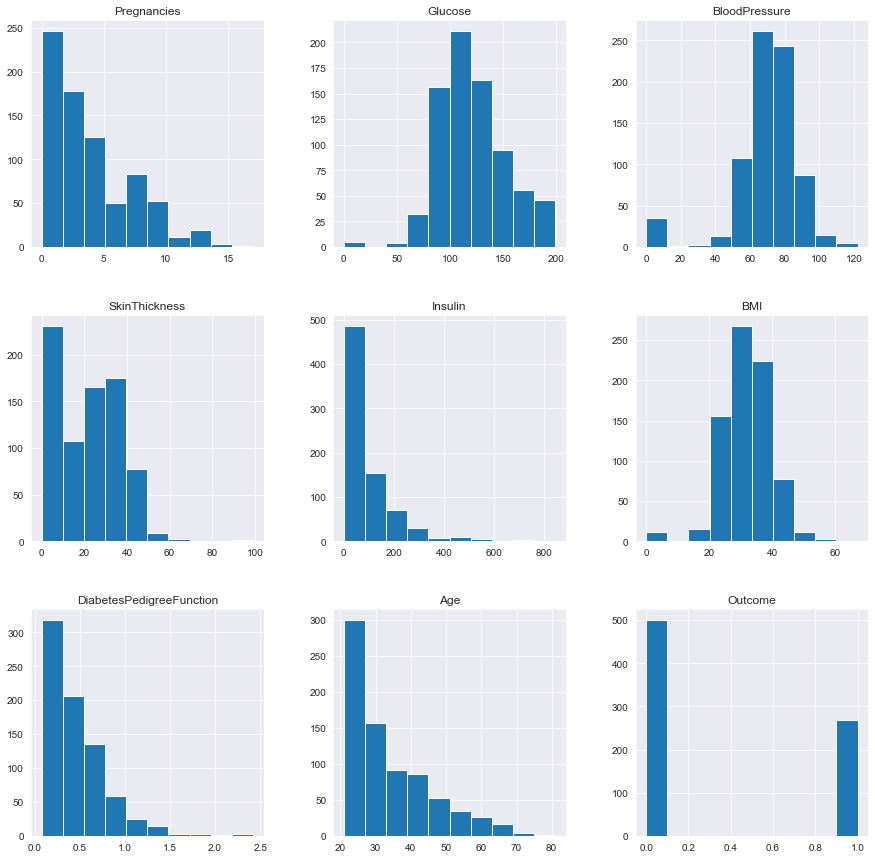

In [8]:
sns.set_style('darkgrid')
data.hist(figsize=(15,15))
plt.show()

Now lets impute the NaN values in original df with appropriate value by looking at the data distributions.

In [9]:
data_copy['Glucose'].fillna(data_copy['Glucose'].mean(), inplace = True)
data_copy['BloodPressure'].fillna(data_copy['BloodPressure'].mean(), inplace = True)
data_copy['SkinThickness'].fillna(data_copy['SkinThickness'].median(), inplace = True)
data_copy['Insulin'].fillna(data_copy['Insulin'].median(), inplace = True)
data_copy['BMI'].fillna(data_copy['BMI'].median(), inplace = True)

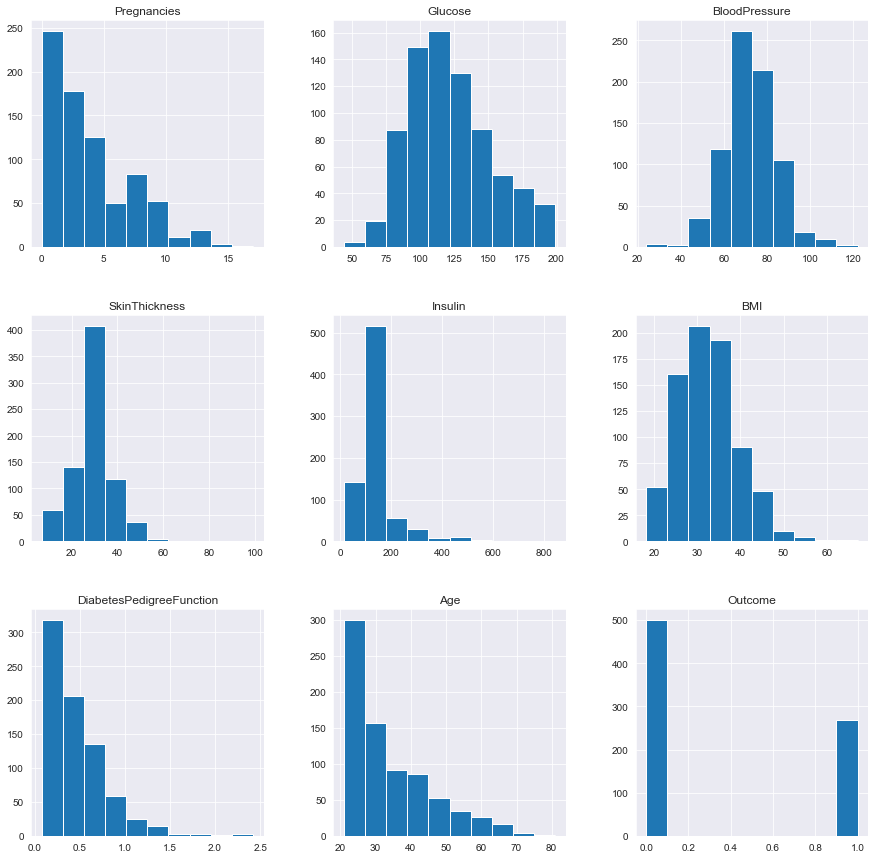

In [10]:
data_copy.hist(figsize=(15,15))
plt.show()

Now the histograms look little tidy and familiar after imputation. No lets look at the distribution of target

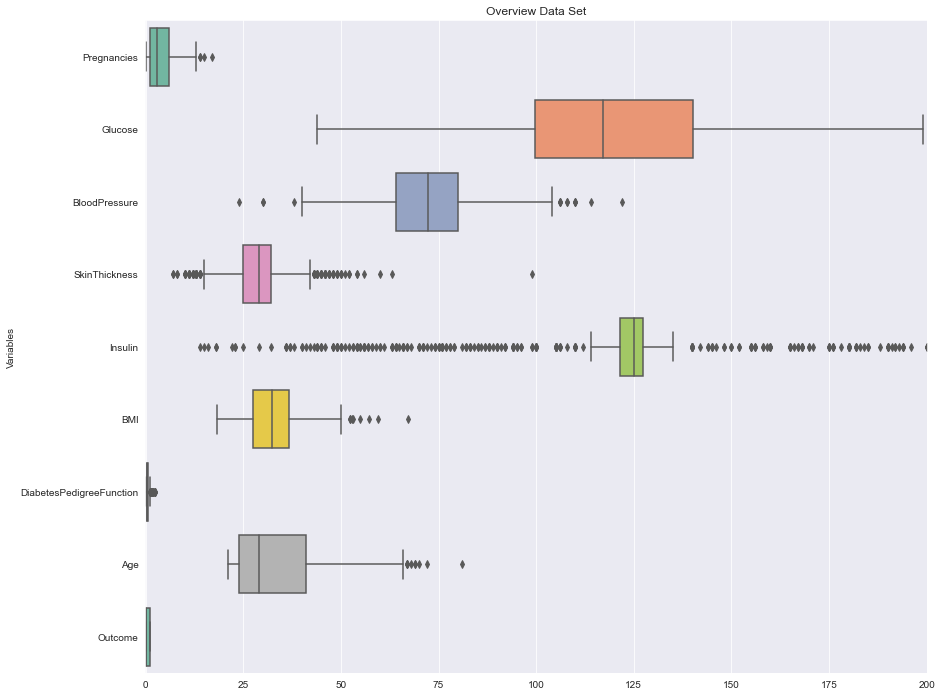

In [11]:
f, ax = plt.subplots(figsize=(14, 12))

ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data_copy, orient = 'h', palette = 'Set2')
plt.show()

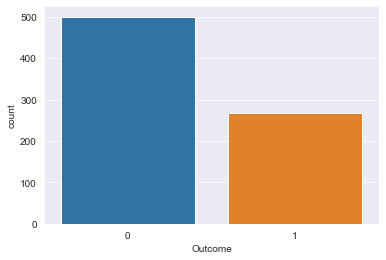

In [12]:
sns.countplot(x = data_copy['Outcome'])
plt.show()

We see our data is not balanced. We have less observations with diabetes.

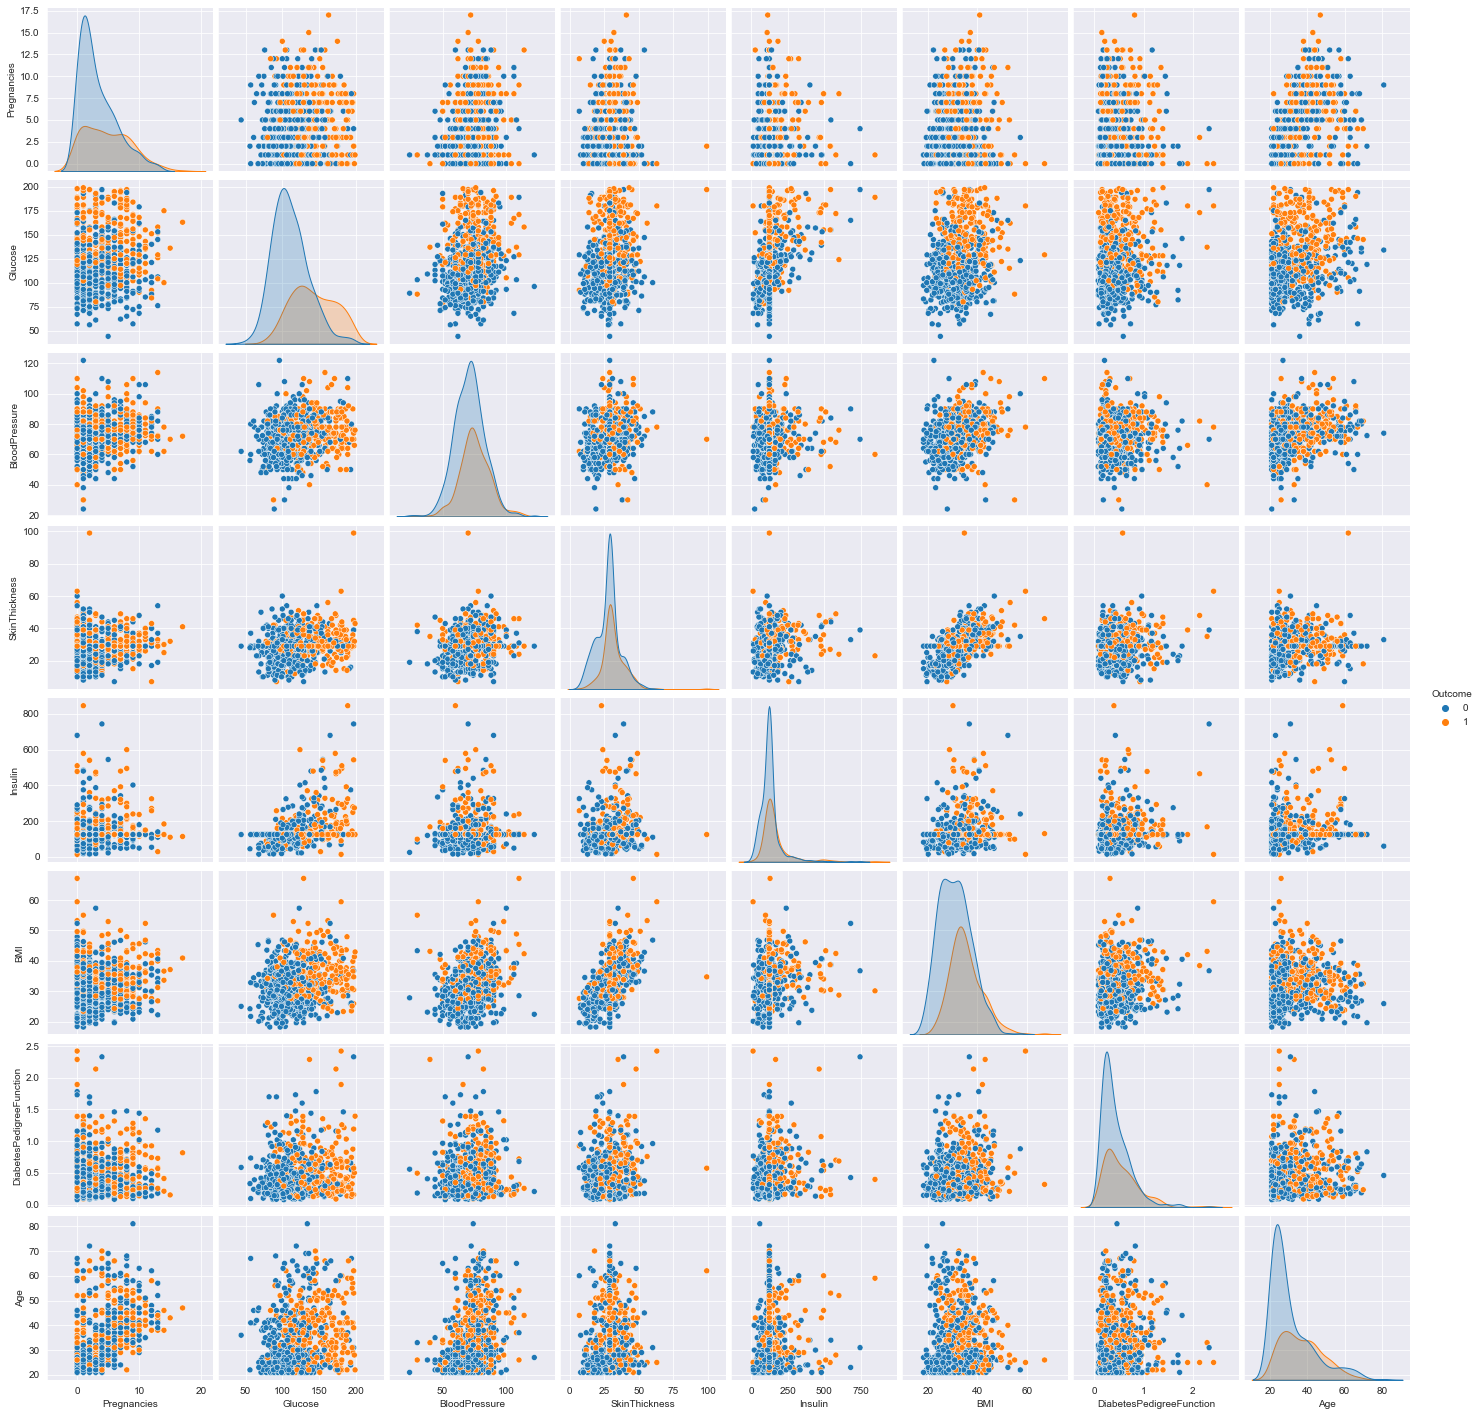

In [13]:
sns.pairplot(data_copy, hue='Outcome')
plt.show()

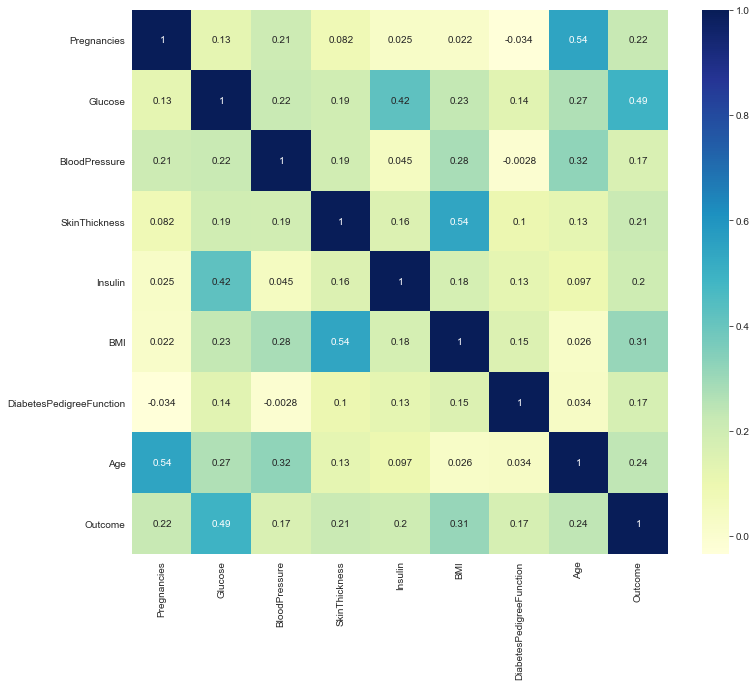

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(data_copy.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [15]:
x = data_copy.drop(columns=['Outcome'])
x = x.to_numpy()
y = data_copy['Outcome']
y = y.to_numpy()

num_folds = 5

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

import optuna
import pickle


def objective(trial):

    params = {"n_neighbors": trial.suggest_int("n_neighbors", 5, 15, step=1, log=False)}

    skf = StratifiedKFold(n_splits=num_folds)
    slr = MinMaxScaler()
    clf = KNeighborsClassifier(**params)

    auc_score = []

    for fold, (train_index, val_index) in enumerate(skf.split(x, y)):
        x_train, y_train, = x[train_index], y[train_index]
        x_val, y_val = x[val_index], y[val_index]

        slr.fit(x_train)
        x_train = slr.transform(x_train)
        x_val = slr.transform(x_val)

        SCALER_PATH = f"trial-{trial.number}-fold-{fold}-slr.pickle"
        pickle.dump(slr, open(SCALER_PATH, "wb"))

        clf.fit(x_train, y_train)

        auc = roc_auc_score(y_val, clf.predict(x_val))
        auc_score.append(auc)

        MODEL_PATH = f"trial-{trial.number}-fold-{fold}-clf.pickle"
        pickle.dump(clf, open(MODEL_PATH, "wb"))

        print(f"Finished trial {trial.number} fold {fold}, saving both scaler and classifier")

    auc_on_folds = np.mean(auc_score)
    print(f"\n>>>> Mean auc_score for trial {trial.number} is {auc_on_folds},  auc_score on folds: {auc_score}\n")

    return auc_on_folds

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print('Number of trials completed:', len(study.trials))
print('Best trail:', study.best_trial)
print('Best params:', study.best_trial.params)

[I 2021-07-24 12:49:20,963] A new study created in memory with name: no-name-08aa6461-6b3c-479f-930d-de6a9275857b
[I 2021-07-24 12:49:21,017] Trial 0 finished with value: 0.7143018867924529 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.7143018867924529.
[I 2021-07-24 12:49:21,067] Trial 1 finished with value: 0.7010265548567435 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.7143018867924529.
[I 2021-07-24 12:49:21,116] Trial 2 finished with value: 0.7062508735150245 and parameters: {'n_neighbors': 10}. Best is trial 0 with value: 0.7143018867924529.


Finished trial 0 fold 0, saving both scaler and classifier
Finished trial 0 fold 1, saving both scaler and classifier
Finished trial 0 fold 2, saving both scaler and classifier
Finished trial 0 fold 3, saving both scaler and classifier
Finished trial 0 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 0 is 0.7143018867924529,  auc_score on folds: [0.6942592592592592, 0.655, 0.6907407407407407, 0.7568867924528301, 0.7746226415094338]

Finished trial 1 fold 0, saving both scaler and classifier
Finished trial 1 fold 1, saving both scaler and classifier
Finished trial 1 fold 2, saving both scaler and classifier
Finished trial 1 fold 3, saving both scaler and classifier
Finished trial 1 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 1 is 0.7010265548567435,  auc_score on folds: [0.6914814814814815, 0.6707407407407406, 0.6957407407407407, 0.7480188679245282, 0.6991509433962264]

Finished trial 2 fold 0, saving both scaler and classifier
Finish

[I 2021-07-24 12:49:21,167] Trial 3 finished with value: 0.70812928022362 and parameters: {'n_neighbors': 12}. Best is trial 0 with value: 0.7143018867924529.
[I 2021-07-24 12:49:21,218] Trial 4 finished with value: 0.7305241090146751 and parameters: {'n_neighbors': 11}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,266] Trial 5 finished with value: 0.70812928022362 and parameters: {'n_neighbors': 12}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,316] Trial 6 finished with value: 0.7062508735150245 and parameters: {'n_neighbors': 10}. Best is trial 4 with value: 0.7305241090146751.


Finished trial 3 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 3 is 0.70812928022362,  auc_score on folds: [0.7000000000000001, 0.6792592592592592, 0.6764814814814815, 0.7524528301886793, 0.7324528301886793]

Finished trial 4 fold 0, saving both scaler and classifier
Finished trial 4 fold 1, saving both scaler and classifier
Finished trial 4 fold 2, saving both scaler and classifier
Finished trial 4 fold 3, saving both scaler and classifier
Finished trial 4 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 4 is 0.7305241090146751,  auc_score on folds: [0.717037037037037, 0.7155555555555557, 0.7035185185185185, 0.7801886792452831, 0.7363207547169811]

Finished trial 5 fold 0, saving both scaler and classifier
Finished trial 5 fold 1, saving both scaler and classifier
Finished trial 5 fold 2, saving both scaler and classifier
Finished trial 5 fold 3, saving both scaler and classifier
Finished trial 5 fold 4, saving both scaler and classif

[I 2021-07-24 12:49:21,368] Trial 7 finished with value: 0.70812928022362 and parameters: {'n_neighbors': 12}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,417] Trial 8 finished with value: 0.7101844863731657 and parameters: {'n_neighbors': 5}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,468] Trial 9 finished with value: 0.7010265548567435 and parameters: {'n_neighbors': 14}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,519] Trial 10 finished with value: 0.6916603773584905 and parameters: {'n_neighbors': 6}. Best is trial 4 with value: 0.7305241090146751.


Finished trial 7 fold 3, saving both scaler and classifier
Finished trial 7 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 7 is 0.70812928022362,  auc_score on folds: [0.7000000000000001, 0.6792592592592592, 0.6764814814814815, 0.7524528301886793, 0.7324528301886793]

Finished trial 8 fold 0, saving both scaler and classifier
Finished trial 8 fold 1, saving both scaler and classifier
Finished trial 8 fold 2, saving both scaler and classifier
Finished trial 8 fold 3, saving both scaler and classifier
Finished trial 8 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 8 is 0.7101844863731657,  auc_score on folds: [0.6735185185185186, 0.7653703703703704, 0.6222222222222222, 0.740754716981132, 0.749056603773585]

Finished trial 9 fold 0, saving both scaler and classifier
Finished trial 9 fold 1, saving both scaler and classifier
Finished trial 9 fold 2, saving both scaler and classifier
Finished trial 9 fold 3, saving both scaler and classifi

[I 2021-07-24 12:49:21,577] Trial 11 finished with value: 0.7143018867924529 and parameters: {'n_neighbors': 15}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,629] Trial 12 finished with value: 0.7277833682739343 and parameters: {'n_neighbors': 7}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,678] Trial 13 finished with value: 0.7277833682739343 and parameters: {'n_neighbors': 7}. Best is trial 4 with value: 0.7305241090146751.
[I 2021-07-24 12:49:21,727] Trial 14 finished with value: 0.7004074074074075 and parameters: {'n_neighbors': 8}. Best is trial 4 with value: 0.7305241090146751.


Finished trial 11 fold 1, saving both scaler and classifier
Finished trial 11 fold 2, saving both scaler and classifier
Finished trial 11 fold 3, saving both scaler and classifier
Finished trial 11 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 11 is 0.7143018867924529,  auc_score on folds: [0.6942592592592592, 0.655, 0.6907407407407407, 0.7568867924528301, 0.7746226415094338]

Finished trial 12 fold 0, saving both scaler and classifier
Finished trial 12 fold 1, saving both scaler and classifier
Finished trial 12 fold 2, saving both scaler and classifier
Finished trial 12 fold 3, saving both scaler and classifier
Finished trial 12 fold 4, saving both scaler and classifier

>>>> Mean auc_score for trial 12 is 0.7277833682739343,  auc_score on folds: [0.7212962962962962, 0.7668518518518519, 0.6742592592592592, 0.7368867924528302, 0.7396226415094339]

Finished trial 13 fold 0, saving both scaler and classifier
Finished trial 13 fold 1, saving both scaler and clas

We have trained our model for different values of k ranging from 5 to 15  and found out that k = 11 gives best prediction across 5 fold cross validation.
Since we have saved both scaler and classifier for every trial and every fold. We will use scaler and model from the best trial to transform and predict our test data. Since we dont have test data in this case. I'm just leaving it here

Below is the code snippet to make predictions.

```
x_test = np.array(df_test)

predictions_from_folds = []

for fold in range(num_folds):
    
    SCALER_PATH = f"trial-{study.best_trial.number}-fold-{fold}-slr.pickle"
    slr = pickle.load(open(SCALER_FILE, 'rb'))
    x_test = slr.transform(x_test)
    
    MODEL_FILE = f"trial-{study.best_trial.number}-fold-{fold}-clf.pickle"'
    clf = pickle.load(open(MODEL_FILE, 'rb'))
    y_test_preds = clf.predict(x_test)
    predictions_from_folds.append(y_test_preds)
    
predictions_from_folds = np.array(predictions_from_folds)
predictions_df = pd.DataFrame(predictions_from_folds)
final_predictions = predictions_df.mode(axis=0)

results = final_predictions.T

```
Note: Some times there can be more than one mode. so its up to us to decide which ones to keep. 